Zadanie 01 - Klątwa wymiaru

Piotr Zawiślan

Celem zadania jest sprawdzenie jak zachowują się pewne wartości wraz ze wzrostem
wymiarowości przestrzeni. Na każde z zadanych pytań da się oczywiście odpowiedzieć poprzez
analityczne wyprowadzenie wzorów opisujących dane zależności. Tym razem chcemy jednak
poćwiczyć również pracę z niedeterministycznymi algorytmami (i raportowanie ich rezultatów) –
dlatego skorzystamy z metody Monte Carlo. Przyjmujemy też, że odległością jest zawsze odległość
Euklidesa.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Tuple, Dict
%matplotlib inline

# Hipersześcian

Zapełniamy hipersześcian losowymi punktami o równomiernym rozkładzie (każdy punkt ma
taką samą szansę na bycie wylosowanym).

In [2]:
def sample_points_from_hypercube(n_samples: int, n_dim: int) -> np.ndarray:
    return np.random.rand(n_samples, n_dim)

In [3]:
test_points = sample_points_from_hypercube(300, 5)

## Kąt między wektorami

Z wygenerowanych punktów losujemy (bez zwracania) dwie pary. Punkty z każdej pary
wyznaczają pewien wektor (są jego początkiem i końcem). Jaki jest kąt między dwoma
wylosowanymi wektorami? Losowanie powtórz wielokrotnie. Jak wygląda rozkład
otrzymanych kątów?

In [4]:
def sample_vectors(points: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    indices = np.random.choice(points.shape[0], 4, replace=False)
    return points[indices[0]] - points[indices[1]], points[indices[2]] - points[indices[3]]

In [5]:
def get_angle(v, u) -> float:
    v /= np.linalg.norm(v)
    u /= np.linalg.norm(u)
    return np.arccos(np.clip(np.dot(v, u), -1.0, 1.0))

In [6]:
v, u = sample_vectors(test_points)
angle = get_angle(v, u)

In [7]:
v, u

(array([ 0.70188626, -0.21670478,  0.4948844 ,  0.46405856, -0.01156726]),
 array([-0.3390565 ,  0.13076261, -0.23183493, -0.49780842, -0.752583  ]))

In [8]:
angle

2.2184970730820397

## Punkty wewnątrz kuli

Ponownie losujemy, ale tym razem tylko jedną parę. Pierwszy z wylosowanych punktów
wyznacza środek pewnej kuli, a odległość do drugiego z nich jest jej promieniem. Jaka część
wygenerowanych początkowo punktów znalazła się wewnątrz takiej kuli?

In [9]:
def sample_sphere(points: np.ndarray) -> Tuple[np.ndarray, float]:
    a, b = points[np.random.choice(points.shape[0], 2, replace=False)]
    return a, np.linalg.norm(a - b)

In [10]:
def get_points_inside_fraction(sphere: Tuple[np.ndarray, float], points: np.ndarray) -> float:
    a, r = sphere
    dist = np.linalg.norm(points - a, axis=1)
    return dist[dist < r].shape[0] / points.shape[0]

In [11]:
test_sphere = sample_sphere(test_points)

In [12]:
test_f = get_points_inside_fraction(test_sphere, test_points)

In [13]:
test_f

0.12666666666666668

## Trzy punkty i różnica odległości

Wylosujmy jeden punkt, a następnie parę innych punktów (łącznie 3 punkty). Obliczmy
odległość między startowym punktem i każdym z dwóch pozostałych. Jakim % średniej z tych
dwóch odległości jest różnica między nimi?

In [14]:
def get_mean_diff_frac(points: np.ndarray) -> float:
    a, x, y = points[np.random.choice(points.shape[0], 3, replace=False)]
    d_x = np.linalg.norm(x - a)
    d_y = np.linalg.norm(y - a)
    mean_x_y = (d_x + d_y) / 2.
    diff = np.abs(d_x - d_y)
    return diff / mean_x_y

In [15]:
get_mean_diff_frac(test_points)

0.23559710828122626

Każdą z tych kwestii rozpatrujemy wielokrotnie.

- Po pierwsze: musimy powtórzyć eksperyment dla każdej rozważanej liczby wymiarów, by
możliwe było zaobserwowanie jak wymiarowość wpływa na rezultaty.

- Po drugie: dla tej samej liczby wymiarów eskperyment również musi być powtórzony
wielokrotnie, gdyż wynik jednego losowania nie jest miarodajny

In [16]:
def get_datasets(n_dim_max: int, n_samples_hc=20000, n_rows_each=2000) \
                                    -> Dict[int, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    data_dict = {"angles": np.empty((n_rows_each, 2)), 
                 "sphere_frac": np.empty((n_rows_each, 2)), 
                 "diff_mean_frac": np.empty((n_rows_each, 2))}
    
    data_dict["angles"][:] = np.nan
    data_dict["sphere_frac"][:] = np.nan
    data_dict["diff_mean_frac"][:] = np.nan
    
    for n_dim in range(2, n_dim_max + 1):
        if n_dim % 5 == 0:
            print(f"current n_dim: {n_dim} / {n_dim_max}")
        points = sample_points_from_hypercube(n_samples_hc, n_dim)
        
        # angles
        angle_arr = np.array([get_angle(*sample_vectors(points)) for _ in range(n_rows_each)])
        
        # inside sphere fractions
        inside_sphere_arr = np.array([get_points_inside_fraction(sample_sphere(points), points) 
                                      for _ in range(n_rows_each)])
        
        # diff / mean fractions
        diff_mean_arr = np.array([get_mean_diff_frac(points) for _ in range(n_rows_each)])
        
        data_dict["angles"] = np.c_[data_dict["angles"], angle_arr]
        data_dict["sphere_frac"] = np.c_[data_dict["sphere_frac"], inside_sphere_arr]
        data_dict["diff_mean_frac"] = np.c_[data_dict["diff_mean_frac"], diff_mean_arr]
        
    return data_dict

In [17]:
result_dict = get_datasets(n_dim_max=60)

current n_dim: 5 / 60
current n_dim: 10 / 60
current n_dim: 15 / 60
current n_dim: 20 / 60
current n_dim: 25 / 60
current n_dim: 30 / 60
current n_dim: 35 / 60
current n_dim: 40 / 60
current n_dim: 45 / 60
current n_dim: 50 / 60
current n_dim: 55 / 60
current n_dim: 60 / 60


In [18]:
angles_df = pd.DataFrame(result_dict["angles"])
angles_df = angles_df.drop(labels=[0, 1], axis=1)
angles_df

,2,3,4,5,6,7,8,9,10,11,...,51,52,53,54,55,56,57,58,59,60
0,1.851733,1.045346,0.913725,1.857421,2.200719,0.800366,2.707159,2.006991,1.579503,1.166781,...,1.367611,1.654924,1.390567,1.381313,1.590365,1.628390,1.588250,1.729972,1.581543,1.562288
1,1.067532,1.921734,2.334562,1.255812,1.758659,1.379995,1.672862,1.154061,1.298325,1.693546,...,1.452392,1.607695,1.712043,1.639188,1.672558,1.522959,1.333328,1.507753,1.628667,1.457047
2,0.656634,1.396141,1.532770,1.500168,0.885352,1.805900,1.662777,1.415587,1.691567,2.137688,...,1.487502,1.470891,1.706574,1.589018,1.402714,1.518365,1.562243,1.848712,1.427826,1.531515
3,2.949389,0.587572,2.649178,2.212345,1.381935,1.197015,1.958763,1.638484,2.213290,1.475672,...,1.688147,1.610447,1.522704,1.462829,1.809720,1.623210,1.452958,1.382909,1.878925,1.559433
4,3.030734,1.883176,1.039321,0.790651,1.400608,1.467139,1.207102,1.742259,1.396337,1.567832,...,1.433787,1.723226,1.671107,1.492194,1.650680,1.403514,1.510300,1.501852,1.898028,1.811980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2.924081,1.643290,0.814332,0.782829,1.252699,0.727562,1.072808,1.172079,1.749164,1.105450,...,1.471390,1.777959,1.640886,1.661371,1.545969,1.466119,1.421242,1.644443,1.641958,1.440479
1996,2.510251,1.340812,1.365994,2.341337,1.756207,1.904177,0.340361,1.517662,1.589745,1.733111,...,1.590155,1.693834,1.487350,1.804413,1.538782,1.774909,1.671754,1.433763,1.664821,1.585376
1997,2.709694,1.609610,1.176969,2.043582,1.791500,1.013187,1.878818,1.899413,2.008233,1.930194,...,1.754371,1.227592,1.702023,1.582315,1.415928,1.819002,1.682654,1.730142,1.679487,1.622801
1998,1.382373,2.201470,2.179347,1.092597,1.826926,1.411765,1.884432,1.570220,1.006174,1.846712,...,1.503600,1.445085,1.511377,1.500297,1.429007,1.438280,1.520305,1.810690,1.458938,1.520131


In [19]:
sphere_df = pd.DataFrame(result_dict["sphere_frac"])
sphere_df = sphere_df.drop(labels=[0, 1], axis=1)
sphere_df

,2,3,4,5,6,7,8,9,10,11,...,51,52,53,54,55,56,57,58,59,60
0,0.07615,0.17975,0.03555,0.45495,0.92435,0.36245,0.42840,0.15725,0.73215,0.73245,...,0.54310,0.69560,0.54635,0.66395,0.21185,0.90530,0.77490,0.49535,0.24415,0.77070
1,0.16410,0.16590,0.13590,0.21025,0.28910,0.58610,0.13070,0.35620,0.78085,0.89710,...,0.64325,0.67640,0.89775,0.96275,0.26565,0.02885,0.10910,0.22830,0.05510,0.73545
2,0.30275,0.14655,0.77740,0.52445,0.42945,0.58415,0.87825,0.56905,0.51755,0.32345,...,0.49580,0.98355,0.62745,0.15450,0.59125,0.23140,0.63670,0.82810,0.74270,0.38200
3,0.85780,0.70880,0.97275,0.99295,0.62980,0.77325,0.14550,0.83840,0.06430,0.68965,...,0.69240,0.23690,0.93910,0.11740,0.37215,0.65660,0.42475,0.75835,0.31750,0.14835
4,0.08555,0.43555,0.76485,0.40540,0.93030,0.51020,0.77370,0.48045,0.64875,0.44270,...,0.22375,0.85490,0.49850,0.08285,0.73240,0.51835,0.99650,0.05240,0.03825,0.15285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.61315,0.66500,0.91705,0.34880,0.49370,0.30220,0.98030,0.86625,0.75580,0.36255,...,0.37705,0.74025,0.58205,0.58670,0.28680,0.44835,0.91635,0.05055,0.08245,0.26335
1996,0.77165,0.78040,0.29890,0.66145,0.58790,0.74725,0.04375,0.11440,0.13435,0.49240,...,0.23370,0.60215,0.98445,0.01975,0.93500,0.37920,0.14480,0.68255,0.35270,0.67340
1997,0.14095,0.65035,0.42140,0.62910,0.21440,0.81905,0.45795,0.82820,0.17670,0.71435,...,0.70585,0.03305,0.51190,0.56825,0.08400,0.71375,0.72650,0.57650,0.41720,0.76550
1998,0.15725,0.82230,0.57340,0.55840,0.06580,0.50145,0.44165,0.54725,0.21260,0.28580,...,0.32145,0.31250,0.01825,0.57185,0.82800,0.03590,0.57925,0.80510,0.05915,0.39565


In [20]:
diff_mean_df = pd.DataFrame(result_dict["diff_mean_frac"])
diff_mean_df = diff_mean_df.drop(labels=[0, 1], axis=1)
diff_mean_df

,2,3,4,5,6,7,8,9,10,11,...,51,52,53,54,55,56,57,58,59,60
0,0.446492,0.102539,0.273697,0.500914,0.103249,0.003478,0.356654,0.103525,0.234890,0.085967,...,0.104762,0.085565,0.078560,0.110104,0.118549,0.012366,0.109795,0.123875,0.261938,0.031714
1,0.282268,0.791982,0.018830,0.156242,0.072159,0.152153,0.133861,0.102696,0.177542,0.267845,...,0.185520,0.125344,0.137231,0.100757,0.089776,0.050628,0.110614,0.035130,0.004619,0.014048
2,0.154897,1.031164,0.298770,0.204661,0.016623,0.034628,0.310309,0.323921,0.042584,0.548564,...,0.067019,0.113064,0.058889,0.078895,0.131316,0.056072,0.037992,0.045608,0.151790,0.029179
3,0.350744,0.400252,0.678979,0.395122,0.028393,0.563277,0.344314,1.195560,0.241220,0.170220,...,0.011461,0.057769,0.089764,0.002342,0.067955,0.037986,0.007425,0.061832,0.128018,0.066424
4,0.526899,0.340536,0.318641,0.055422,0.534908,0.031573,0.373849,0.313954,0.126433,0.209230,...,0.078916,0.079066,0.026571,0.142551,0.169333,0.053229,0.062941,0.059380,0.033316,0.057511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.305591,0.567607,1.403149,0.309998,0.148801,0.323932,0.155268,0.005589,0.068162,0.097220,...,0.123522,0.060597,0.116795,0.057526,0.025122,0.036443,0.064199,0.226587,0.063951,0.053002
1996,0.413372,0.139642,0.190003,0.246716,0.149850,0.119359,0.135251,0.033202,0.574340,0.203052,...,0.030072,0.051783,0.237367,0.003321,0.002656,0.130169,0.012523,0.109705,0.009477,0.024914
1997,0.991331,0.227080,0.282465,0.622720,0.027482,0.056954,0.694043,0.163831,0.021043,0.074087,...,0.043771,0.067424,0.179091,0.031970,0.072131,0.080502,0.158388,0.140716,0.016773,0.020633
1998,1.036043,0.059172,0.239991,0.420656,0.162636,0.056463,0.049192,0.427578,0.271970,0.523634,...,0.145874,0.043838,0.186494,0.031675,0.002418,0.069104,0.042219,0.038963,0.108439,0.024105


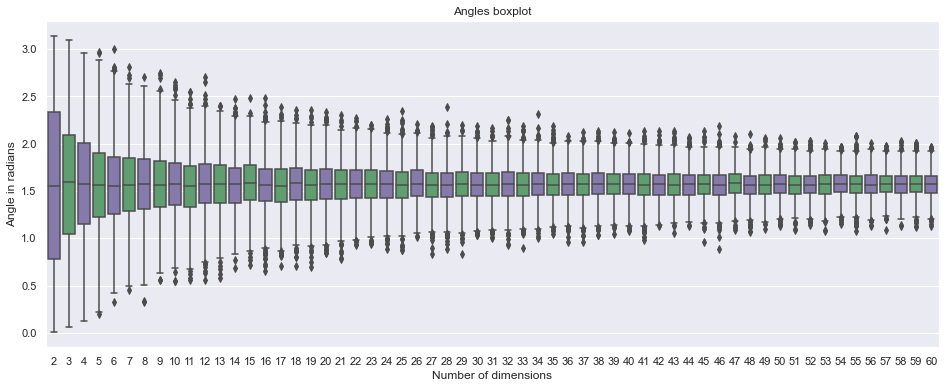

In [21]:
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc={'figure.figsize':(16, 6)})
sns.boxplot(palette=["m", "g"], data=angles_df)
plt.xlabel("Number of dimensions")
plt.ylabel("Angle in radians")
plt.title("Angles boxplot")
plt.show()

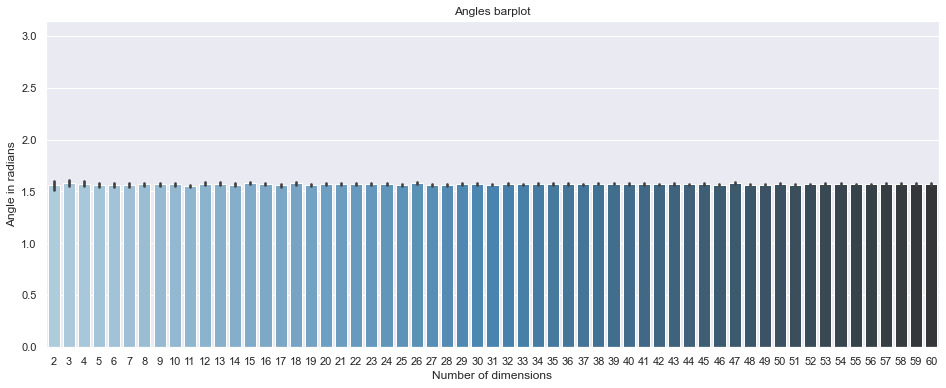

In [22]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16, 6)})
sns.barplot(data=angles_df, palette="Blues_d")
plt.ylim((0., 3.14))
plt.xlabel("Number of dimensions")
plt.ylabel("Angle in radians")
plt.title("Angles barplot")
plt.show()

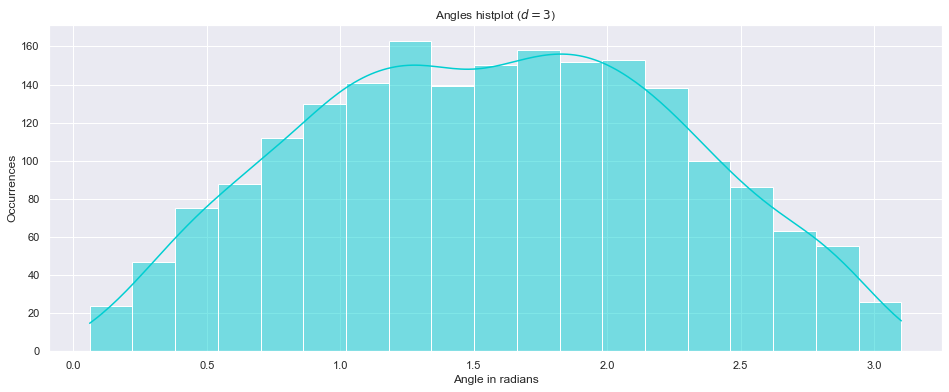

In [40]:
sns.set_theme(style="ticks", palette="deep")
sns.set(rc={'figure.figsize':(16, 6)})
sns.histplot(data=angles_df.loc[:, 3], kde=True, color="darkturquoise")
plt.xlabel("Angle in radians")
plt.ylabel("Number of occurrences")
plt.title("Angles histplot ($d=3$)")
plt.show()

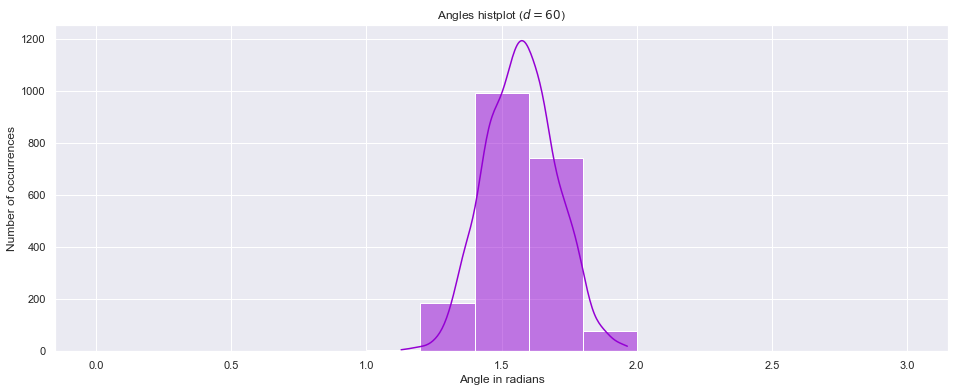

In [41]:
sns.set_theme(style="ticks", palette="deep")
sns.set(rc={'figure.figsize':(16, 6)})
sns.histplot(data=angles_df.loc[:, 60], kde=True, color="darkviolet", binwidth=0.2, binrange=(0., 3.))
plt.xlabel("Angle in radians")
plt.ylabel("Number of occurrences")
plt.title("Angles histplot ($d=60$)")
plt.show()

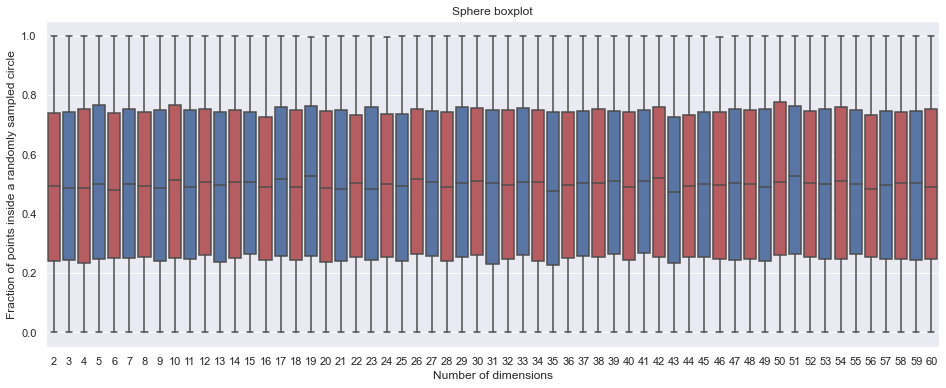

In [23]:
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc={'figure.figsize':(16, 6)})
sns.boxplot(palette=["r", "b"], data=sphere_df)
plt.xlabel("Number of dimensions")
plt.ylabel("Fraction of points inside a randomly sampled circle")
plt.title("Sphere boxplot")
plt.show()

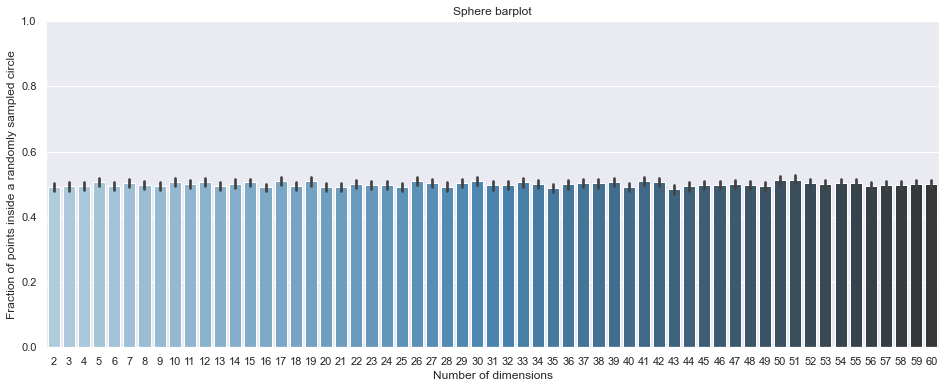

In [24]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16, 6)})
sns.barplot(data=sphere_df, palette="Blues_d")
plt.ylim((0., 1.))
plt.xlabel("Number of dimensions")
plt.ylabel("Fraction of points inside a randomly sampled circle")
plt.title("Sphere barplot")
plt.show()

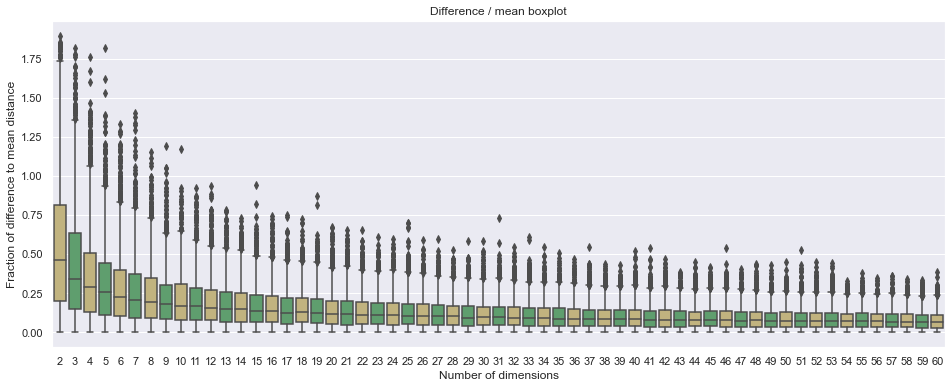

In [25]:
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc={'figure.figsize':(16, 6)})
sns.boxplot(palette=["y", "g"], data=diff_mean_df)
plt.xlabel("Number of dimensions")
plt.ylabel("Fraction of difference to mean distance")
plt.title("Difference / mean boxplot")
plt.show()

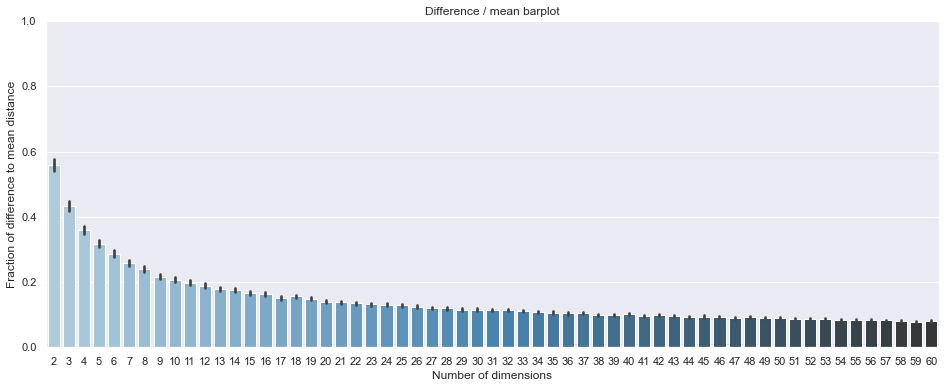

In [26]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16, 6)})
sns.barplot(data=diff_mean_df, palette="Blues_d")
plt.ylim((0., 1.))
plt.xlabel("Number of dimensions")
plt.ylabel("Fraction of difference to mean distance")
plt.title("Difference / mean barplot")
plt.show()

Dla wszystkich podpunktów tworzymy odpowiednie wykresy (liniowy, punktowy, histogram - co
akurat pasuje), dobierając rozsądny (pozwalający na skończenie obliczeń tego samego wieczora ;])
zakres badanych wymiarów i liczbę punktów generowanych we wnętrzach sześcianów. W
konsekwencji - typowy wykres powinien przedstawiać średni rezultat z rozsądnej liczby powtórzeń
eksperymentu oraz jego odchylenie standardowe, zaprezentowane jako tzw. error-bars (tylko w
ten sposób można wiarygodnie przedstawiać informacje z obserwacji zjawisk losowych). Na
przyszłość przypominam również o podpisywaniu osi i uwzględnianiu informacji o jednostkach
(jeżeli takowe występują). Warto wykorzystać zadanie jako pretekst do oswojenia się z wybraną
biblioteką do rysowania wykresów (jeżeli takiej jeszcze nie mamy).

PS. Przypominam, że w ramach zadania wrzucamy raport w formacie PDF i ZIP z kodem.